In [1]:
import torch
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import tqdm

from torch.utils.cpp_extension import load

global conv2d_op 
conv2d_op = load(name='conv2d', sources=['models/modules/kernels/conv2d_cuda.cpp', 'models/modules/kernels/conv2d_cuda_kernel.cu'])

def calc_bit_mask(n):
    if n <= 0:
        return -(2**(-n))
    else:
        return -(2**(23-n))

In [2]:
def Q(x):
    return 0.5 - 0.5*special.erf(x/np.sqrt(2))

def qi(macc, i):
    return 2*Q(2**macc / np.sqrt(i))*(1 - 2*Q(2**macc / np.sqrt(i-1)))
    
def alpha_jr(macc, mp, jr):
    tmp = 2**(macc - 3*mp)/3
    J2 = [(2**j) for j in range(1,jr)]
    return tmp*np.sum([ jj * (jj- 1)*(2*jj-1)  for jj in J2])

def alpha(macc, mp):
    return alpha_jr(macc, mp, mp+1)

def qjr(macc, mp, n, jr):
    N = 2**(macc -mp + jr) ## N_{jr-1}
    return N*2*Q(2**(macc-mp + jr - 1)/ np.sqrt(n))*(1-2*Q(2**(macc-mp+jr)/(np.sqrt(n))))

def k1(macc, mp, n):
    a = alpha(macc,mp)
    return np.sum([qi(macc,i)  for i in range(2,n) if i>a])

def k2(macc, mp, n):
    return np.sum([qjr(macc,mp, n, jr)  for jr in range(2,mp+1) if n > alpha_jr(macc,mp,jr)])

def k3(macc, mp, n):
    return 1 - 2*Q(2**(macc - mp + 1)/ np.sqrt(n))

def kfunc(macc, mp, n):
    return k1(macc, mp,n) + k2(macc, mp,n) + k3(macc, mp,n)

def relu(x):
    if x > 0:
        return x
    else:
        return 0

def VRR(macc, mp, n, chunks = 1):
    
    if chunks > 1:
        assert(n % chunks == 0)
        n1 = chunks
        n2 = n / chunks
        return VRR(macc, mp, n1)* VRR(macc, min(macc, mp + int(np.log(chunks) /np.log(2))) , n2) 
    
    k3_ = k3(macc, mp, n)
    k = kfunc(macc, mp, n)
    a = alpha(macc, mp)
    
    tmp1 = np.sum([(i-a)*qi(macc,i) for i in range(2,n) if i > a] )
    tmp2 = np.sum([relu(n- alpha_jr(macc, mp, jr)) * qjr(macc,mp,n , jr)  for jr in range(2,mp+1)] )
    
    return (tmp1 + tmp2 + n*k3_)/ (n*k)
    

100%|██████████| 200/200 [00:06<00:00, 32.70it/s]
/home/yaniv/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
100%|██████████| 200/200 [00:05<00:00, 33.95it/s]
/home/yaniv/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
100%|██████████| 200/200 [00:06<00:00, 33.07it/s]
/home/yaniv/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
100%|██████████| 200/200 [00:06<00:00, 32.85it/s] 
/home/yaniv/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


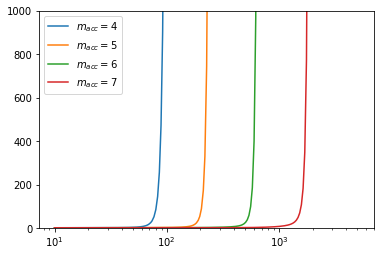

In [3]:
tot = 200
mp =5
results = {}
##X = [int(i) for i in np.logspace(1,6,tot)]
X = [int(i) for i in np.logspace(1,4,tot)]

#maccs = [4,5,6,7,8,9,10,11,12,13,14,15,16]
maccs = [4,5,6,7]

for macc in maccs:
    vrr = np.zeros(tot)
    for i,x in tqdm.tqdm(enumerate(X), total = tot ):
        vrr[i] =  VRR(macc, mp, x)

    plt.semilogx(X,np.exp(X*(1-vrr)), label = "$m_{acc} = %d$" % macc)

    results[macc] = vrr.copy()
    
plt.ylim([0,1000])
plt.legend()


In [3]:
maccs.reverse()

best_macc = np.zeros(tot, dtype=int)
for i,x  in enumerate(X):
    for macc in maccs:
        if results[macc][i] > 1- 4/x:
            best_macc[i] = macc        
        
maccs.reverse()


NameError: name 'maccs' is not defined

Text(0, 0.5, 'mantisa bits required')

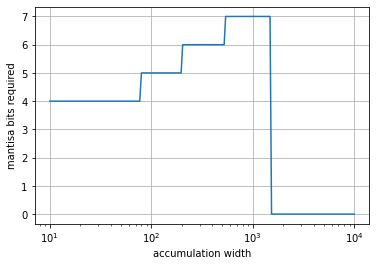

In [5]:
plt.semilogx(X, best_macc)
plt.grid()
plt.xlabel("accumulation width")
plt.ylabel("mantisa bits required")


In [92]:
A = torch.randn([5,3])
print(A)
Amasked = conv2d_op.bitmask(A.cuda(), calc_bit_mask(10) , 1)
print(Amasked)


tensor([[-0.6206,  1.2851,  1.1877],
        [ 0.1930, -0.3293, -0.4535],
        [-0.2562,  1.5353,  2.4231],
        [ 0.1469,  2.3733, -1.3126],
        [-0.3464,  0.8493,  0.2689]])
tensor([[-0.6201,  1.2842,  1.1875],
        [ 0.1929, -0.3291, -0.4534],
        [-0.2561,  1.5352,  2.4219],
        [ 0.1469,  2.3730, -1.3125],
        [-0.3462,  0.8491,  0.2688]], device='cuda:0')


In [3]:


def sim_VRR(macc, mp, n, N=1000):
    iters = int((N*n+200000-1)/200000)
    j = 0
    
    accumulator_macc = torch.zeros([N], dtype = torch.float).cuda()
    accumulator_full = torch.zeros([N], dtype = torch.float).cuda()
    
    bitmask_mp = calc_bit_mask(mp)
    bitmask_macc = calc_bit_mask(macc)
    
    
    
    per_iter = int(N/iters)
    for j in range(iters):
        s = j*per_iter
        e = min((j+1)*per_iter, N)
        cnt = e-s
        
        rand_vec = torch.randn([cnt,n], dtype = torch.float).cuda()
        rand_vec = conv2d_op.bitmask(rand_vec, bitmask_mp, 1)

        for i in range(n):
            accumulator_full[s:e] = accumulator_full[s:e] + rand_vec[:,i]
            accumulator_macc[s:e] = accumulator_macc[s:e] + rand_vec[:,i]
            accumulator_macc[s:e] = conv2d_op.bitmask(accumulator_macc[s:e].unsqueeze(1), bitmask_macc, 1).squeeze()

    Var_swamping = accumulator_macc.std()
    Var = accumulator_full.std()
    
    
    
    ##print(accumulator_macc)
    ##print(accumulator_full)

    vrr = (Var_swamping**2/Var**2).cpu()
    return vrr
        
    

In [4]:
%%time
macc = 6
mp = 23
n = 1024*32

simvrr = sim_VRR(macc,mp,n)
vrr = VRR(macc+1,mp,n)
print(f"simvrr = {simvrr}")
print(f"sim_v(n) = {np.exp(n*(1-simvrr))}")
print(f"vrr = {vrr}")
print(f"v(n) = {np.exp(n*(1-vrr))}")

RuntimeError: CUDA error: an illegal instruction was encountered

In [48]:
np.exp(n*(1-vrr))

1.007622924377645